In [72]:
import torch
import torchvision
import torchvision.transforms as transforms

In [73]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

In [74]:
download_path = "../prototype/pytorch_prototype/data"

trainset = torchvision.datasets.CIFAR10(
    root=download_path,
    train=True,
    download=True,
    transform=transform)

testset = torchvision.datasets.CIFAR10(
    root=download_path,
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
import random

# 複数クラスラベルのデータセットから指定クラスラベルの1データセットを取得
def get_one_label_data(class_label, dataset):
    new_data = []
    for data in dataset:
        label = data[1]
        if label == class_label:
            new_data.append(data)
    return new_data

# 複数クラスラベルのデータセットから指定クラスラベルのtrain, testデータセットを取得
def get_one_label_dataset(class_label, train, test):
    train = get_one_label_data(class_label, train)
    test = get_one_label_data(class_label, test)
    return train, test

# 1データセットのラベルを指定のラベルに変更
def change_label_data(new_label, dataset):
    new_data = []
    for data in dataset:
        new_data.append((data[0], new_label))
    return new_data

# train, testデータセットのラベルを指定のラベルに変更
def change_label_dataset(new_label, train, test):
    train = change_label_data(new_label, train)
    test = change_label_data(new_label, test)
    return train, test

# 指定データ数分のtrainデータをランダムに取得
# data_n: 1クラスのデータ数
def choice_train_at_random(data_n, train):
    train = random.sample(train, data_n)
    return train

# 指定クラスラベルリストのtrain, testデータセットを取得
def get_specific_label_dataset(class_label_list, train, test, data_n=None):
    new_train = []
    new_test = []
    for i, label in enumerate(class_label_list):
        got_train, got_test = get_one_label_dataset(label, train, test)
        got_train, got_test = change_label_dataset(i, got_train, got_test)
        if data_n != None:
            got_train = choice_train_at_random(data_n, got_train)
        new_train += got_train
        new_test += got_test
    return new_train, new_test

## 1クラスのデータ数:5000で確認

In [76]:
class_label_list = [1,2,8]
new_train, new_test = get_specific_label_dataset(class_label_list, trainset, testset, 5000)

In [77]:
print(len(new_train))
print(len(new_test))

15000
3000


In [78]:
batch_size = 5

trainloader = torch.utils.data.DataLoader(
    new_train,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

testloader = torch.utils.data.DataLoader(
    new_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

In [79]:
# feature_df作成

import pandas as pd
from test_assets.model import pytorch_cifar10

classes = ["automobile", "bird", "ship"]
df = pd.DataFrame()
df_data_name = []
df_data = []
df_features = []
df_labels = []

param_path = "./test_assets/learned_model/v8.pth"
param = torch.load(param_path)
model = pytorch_cifar10.LeNet(3)
model.load_state_dict(param)
count = 0

for (inputs, labels) in trainloader:
    outputs, feature = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    for i in range(len(inputs)):
        df_data_name.append("data_" + str(count))
        df_data.append(inputs[i])
        df_features.append(feature[i].data)
        df_labels.append(labels[i].item())
        count += 1

df["data_name"] = df_data_name
df["data"] = df_data
df["feature"] = df_features
df["label"] = df_labels

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

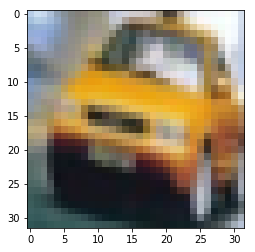

In [87]:
imshow(torchvision.utils.make_grid(df["data"][5])) # query画像, query_index:5

In [88]:
df_add_cosine = df.copy()
df_add_distance = df.copy()

### query画像とのコサイン類似度を追加

In [89]:
import scipy.spatial.distance as dis

query_index = 5
df_cosine = []
query = df["feature"][query_index]
for target in df["feature"].values:
    cosine = 1 - dis.cosine(query, target)
    df_cosine.append(cosine)

df_add_cosine["cosine"] = df_cosine

In [91]:
df_add_cosine_sorted = df_add_cosine.sort_values("cosine", ascending=False)
df_add_cosine_sorted = df_add_cosine_sorted.reset_index()

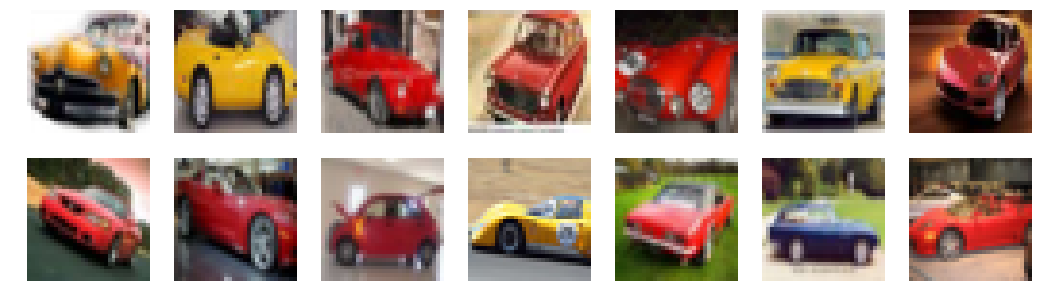

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が高い上位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_cosine_sorted[df_add_cosine_sorted.label==0]["data"][1:15].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

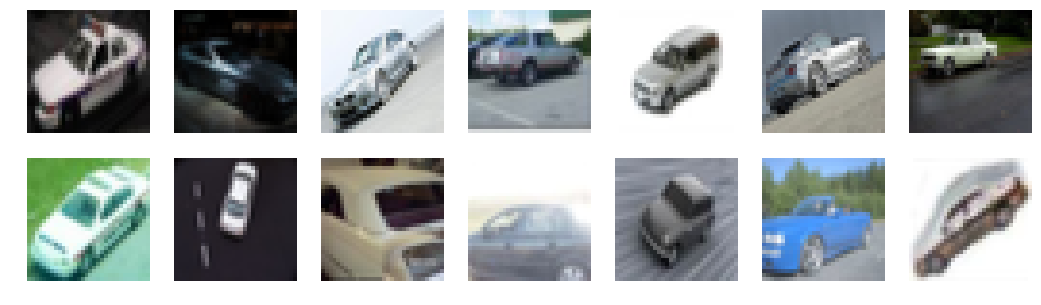

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が低い下位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_cosine_sorted[df_add_cosine_sorted.label==0]["data"][-14:].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

### query画像とのユークリッド距離を追加

In [95]:
# ユークリッド距離を追加
import numpy as np

query_index = 5
df_distance = []
query = np.asarray(df["feature"][query_index])
for target in df["feature"].values:
    target = np.asarray(target)
    distance = np.sqrt(((query-target)**2).sum())
    df_distance.append(distance)

df_add_distance["distance"] = df_distance

In [96]:
df_add_distance_sorted = df_add_distance.sort_values("distance", ascending=True)
df_add_distance_sorted = df_add_distance_sorted.reset_index()

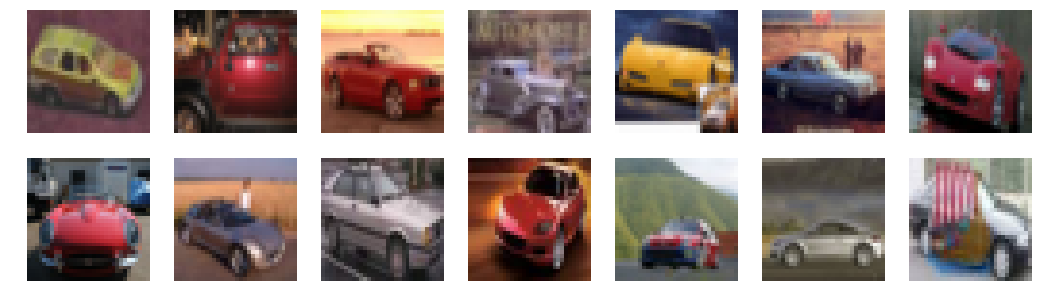

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が高い上位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_distance_sorted[df_add_distance_sorted.label==0]["data"][1:15].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

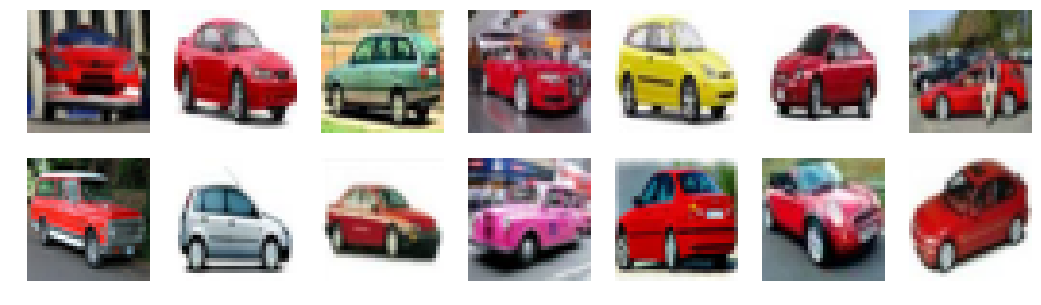

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が低い下位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_distance_sorted[df_add_distance_sorted.label==0]["data"][-14:].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

## 1クラスのデータ数:50で確認

In [5]:
class_label_list = [1,2,8]
new_train, new_test = get_specific_label_dataset(class_label_list, trainset, testset, 50)

In [6]:
print(len(new_train))
print(len(new_test))

150
3000


In [7]:
batch_size = 5

trainloader = torch.utils.data.DataLoader(
    new_train,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

testloader = torch.utils.data.DataLoader(
    new_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

In [8]:
# feature_df作成

import pandas as pd
from test_assets.model import pytorch_cifar10

classes = ["automobile", "bird", "ship"]
df = pd.DataFrame()
df_data_name = []
df_data = []
df_features = []
df_labels = []

param_path = "./test_assets/learned_model/v8.pth"
param = torch.load(param_path)
model = pytorch_cifar10.LeNet(3)
model.load_state_dict(param)
count = 0

for (inputs, labels) in trainloader:
    outputs, feature = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    for i in range(len(inputs)):
        df_data_name.append("data_" + str(count))
        df_data.append(inputs[i])
        df_features.append(feature[i].data)
        df_labels.append(labels[i].item())
        count += 1

df["data_name"] = df_data_name
df["data"] = df_data
df["feature"] = df_features
df["label"] = df_labels

In [22]:
df

,data_name,data,feature,label
0,data_0,"[[[tensor(0.6706), tensor(0.5137), tensor(0.41...","[tensor(0.4480), tensor(1.0073), tensor(0.1741...",0
1,data_1,"[[[tensor(-0.1608), tensor(-0.1373), tensor(-0...","[tensor(0.0409), tensor(0.5815), tensor(0.), t...",0
2,data_2,"[[[tensor(-0.1451), tensor(-0.0980), tensor(-0...","[tensor(0.5591), tensor(0.9450), tensor(0.2161...",0
3,data_3,"[[[tensor(0.6627), tensor(0.6627), tensor(0.69...","[tensor(0.4898), tensor(0.5856), tensor(0.1126...",0
4,data_4,"[[[tensor(0.0039), tensor(-0.1608), tensor(-0....","[tensor(0.5964), tensor(0.6787), tensor(0.0724...",0
5,data_5,"[[[tensor(-0.6549), tensor(-0.6235), tensor(-0...","[tensor(0.6670), tensor(0.2794), tensor(0.6129...",0
6,data_6,"[[[tensor(0.9451), tensor(0.9137), tensor(0.92...","[tensor(0.2814), tensor(1.3171), tensor(0.2351...",0
7,data_7,"[[[tensor(-0.5137), tensor(-0.5765), tensor(-0...","[tensor(0.6894), tensor(0.8074), tensor(0.1776...",0
8,data_8,"[[[tensor(-0.7098), tensor(-0.5686), tensor(-0...","[tensor(0.2911), tensor(0.5657), tensor(0.), t...",0
9,data_9,"[[[tensor(1.), tensor(1.), tensor(1.), tensor(...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",0


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

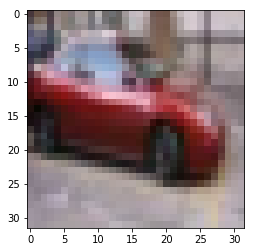

In [13]:
imshow(torchvision.utils.make_grid(df["data"][0]))

In [14]:
# コサイン距離 0が最も似ている, 2が最も離れている
import numpy as np
import scipy.spatial.distance as dis

In [66]:
# ユークリッド距離
a = np.asarray(df["feature"][0])
b = np.asarray(df["feature"][1])
print(np.sqrt(np.power(a-b, 2).sum()))
print(np.sqrt(((a-b)**2).sum()))

6.0035024
6.0035024


In [15]:
df_add_cosine = df.copy()
df_add_distance = df.copy()

In [26]:
# コサイン類似度を追加
import numpy as np
import scipy.spatial.distance as dis

df_cosine = []
query = df["feature"][0]
for target in df["feature"].values:
    cosine = 1 - dis.cosine(query, target)
    df_cosine.append(cosine)

df_add_cosine["cosine"] = df_cosine

In [27]:
df_add_cosine

,data_name,data,feature,label,cosine
0,data_0,"[[[tensor(-0.4431), tensor(-0.1922), tensor(-0...","[tensor(0.5997), tensor(0.8072), tensor(0.1233...",0,1.000000
1,data_1,"[[[tensor(0.9137), tensor(0.9059), tensor(0.90...","[tensor(0.1972), tensor(0.2324), tensor(0.0782...",0,0.646984
2,data_2,"[[[tensor(0.4118), tensor(0.2392), tensor(0.23...","[tensor(0.4334), tensor(1.3911), tensor(0.), t...",0,0.746725
3,data_3,"[[[tensor(0.4745), tensor(0.4980), tensor(0.73...","[tensor(0.), tensor(0.3194), tensor(0.5106), t...",0,0.710123
4,data_4,"[[[tensor(0.4431), tensor(0.4196), tensor(0.49...","[tensor(0.4864), tensor(0.9700), tensor(0.3181...",0,0.741158
5,data_5,"[[[tensor(0.1059), tensor(0.0667), tensor(0.05...","[tensor(0.7519), tensor(0.5956), tensor(0.3257...",0,0.755293
6,data_6,"[[[tensor(-0.0824), tensor(-0.1137), tensor(-0...","[tensor(0.6698), tensor(0.5075), tensor(0.), t...",0,0.669219
7,data_7,"[[[tensor(1.), tensor(0.9843), tensor(0.9843),...","[tensor(0.7839), tensor(0.), tensor(0.), tenso...",0,0.671528
8,data_8,"[[[tensor(-0.2078), tensor(-0.3020), tensor(-0...","[tensor(0.2190), tensor(0.4270), tensor(0.), t...",0,0.525871
9,data_9,"[[[tensor(-0.5843), tensor(-0.4902), tensor(-0...","[tensor(0.9143), tensor(0.9533), tensor(0.2876...",0,0.798364


In [44]:
df_add_cosine_sorted = df_add_cosine.sort_values("cosine", ascending=False)
df_add_cosine_sorted = df_add_cosine_sorted.reset_index()

In [45]:
df_add_cosine_sorted[:5]

,index,data_name,data,feature,label,cosine
0,0,data_0,"[[[tensor(-0.4431), tensor(-0.1922), tensor(-0...","[tensor(0.5997), tensor(0.8072), tensor(0.1233...",0,1.000000
1,22,data_22,"[[[tensor(-0.0824), tensor(-0.3098), tensor(-0...","[tensor(0.7342), tensor(0.6139), tensor(0.5443...",0,0.841511
2,29,data_29,"[[[tensor(-0.2314), tensor(-0.2314), tensor(-0...","[tensor(0.4244), tensor(0.5408), tensor(0.), t...",0,0.835115
3,38,data_38,"[[[tensor(0.4118), tensor(0.2863), tensor(0.21...","[tensor(0.1521), tensor(0.5466), tensor(0.4386...",0,0.829774
4,32,data_32,"[[[tensor(0.3333), tensor(0.1922), tensor(0.10...","[tensor(0.8137), tensor(1.0276), tensor(0.1418...",0,0.826913


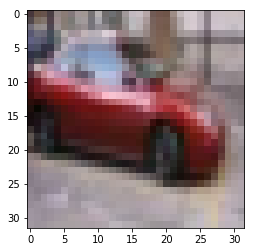

In [49]:
imshow(torchvision.utils.make_grid(df_add_cosine_sorted["data"][0])) #query画像を表示

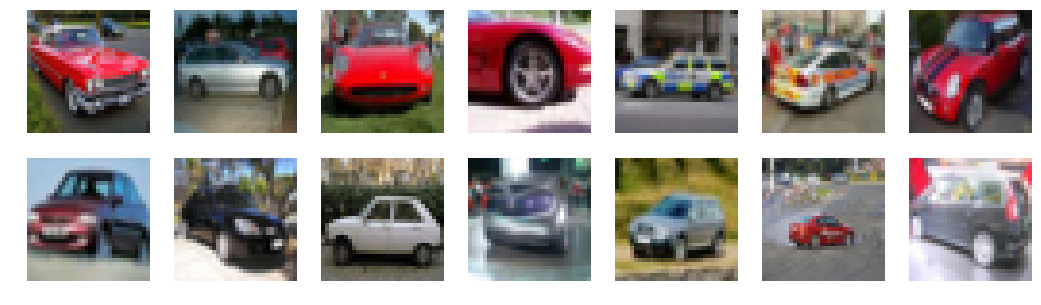

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が高い上位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_cosine_sorted[df_add_cosine_sorted.label==0]["data"][1:15].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

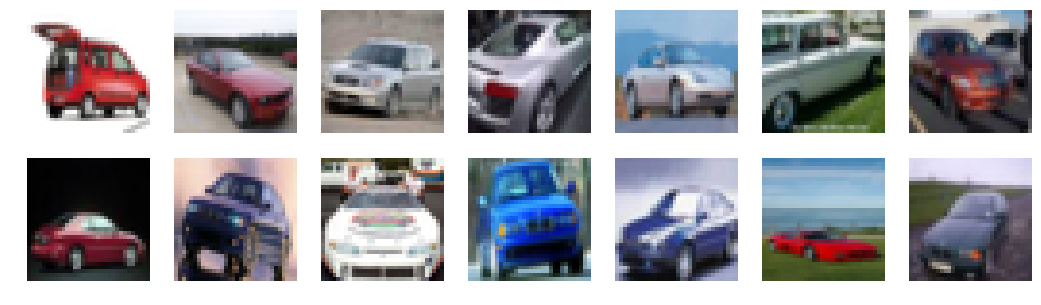

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が低い下位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_cosine_sorted[df_add_cosine_sorted.label==0]["data"][-14:].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

In [56]:
df_add_cosine_sorted["label"].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1])

In [66]:
# ユークリッド距離を追加
import numpy as np

df_distance = []
query = np.asarray(df["feature"][0])
for target in df["feature"].values:
    target = np.asarray(target)
    distance = np.sqrt(((query-target)**2).sum())
    df_distance.append(distance)

df_add_distance["distance"] = df_distance

In [68]:
df_add_distance_sorted = df_add_distance.sort_values("distance", ascending=True)
df_add_distance_sorted = df_add_distance_sorted.reset_index()

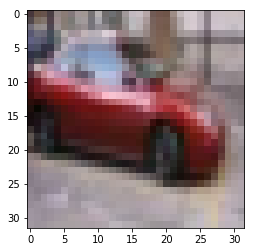

In [67]:
imshow(torchvision.utils.make_grid(df_add_cosine_sorted["data"][0])) #query画像を表示

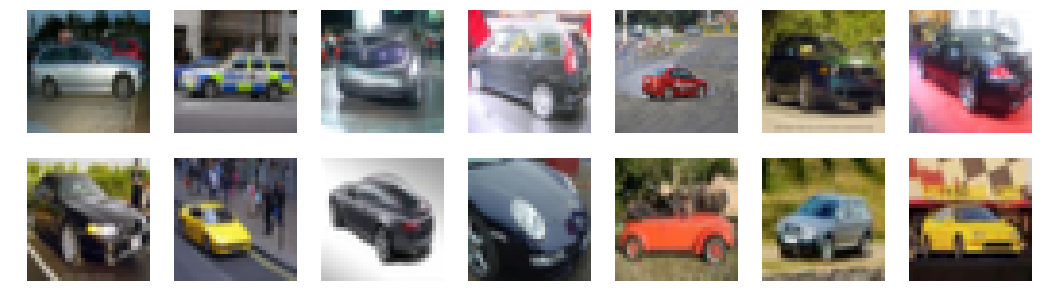

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が高い上位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_distance_sorted[df_add_distance_sorted.label==0]["data"][1:15].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()

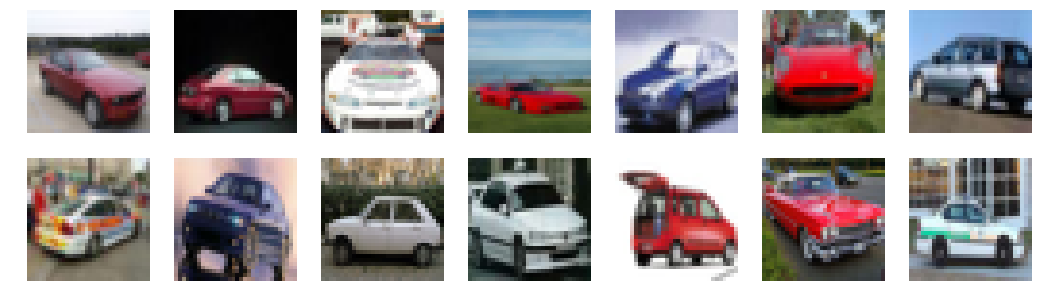

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# queryと類似度が高い上位14の車画像
fig = plt.figure(figsize=(18,5))
for i, img in enumerate(df_add_distance_sorted[df_add_distance_sorted.label==0]["data"][-14:].values, 1):
    img = img/2+0.5
    npimg = img.numpy()
    ax = fig.add_subplot(2, 7, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()

plt.show()